In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from math import floor

# Data Cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


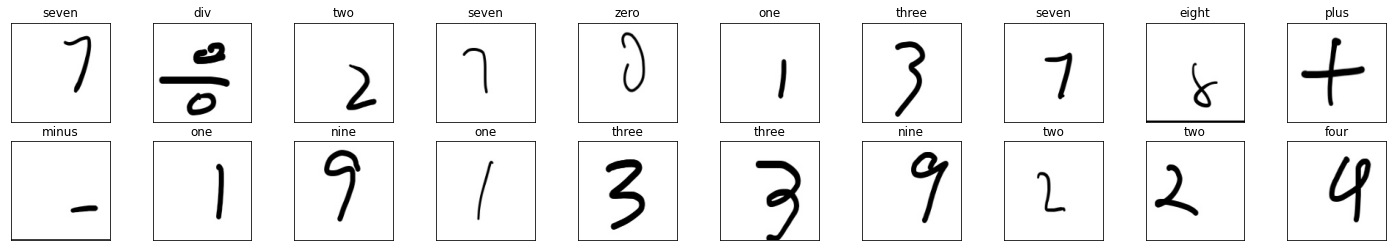

In [ ]:
#data cleaning

use_GPU = True
# The path is different, so I made user_name
user_name = 'Suzy'

# Loading Data
batch_size = 30
num_workers = 1

# Dataset folder location on Google Drive
if(user_name == 'HeeSeung'):
  math_img_folder = '/content/drive/My Drive/APS360 Colab Notebooks/Group 22/KaggleDataset/'
elif(user_name == 'Suzy'):
  math_img_folder = '/content/drive/MyDrive/APS360_Group_22/KaggleDataset/'
elif (user_name == 'Grace'):
  math_img_folder = '/content/drive/MyDrive/Y3/APS360 Group 22/KaggleDataset/'
elif (user_name == 'Richard'):
  math_img_folder = '/content/drive/MyDrive/APS360/KaggleDataset'

# Transform Images to Tensors of pixel size 135 x 135
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((135, 135))])

# Three folders within math_img_folder  # 60% Training, 20% Validation, and 20% Testing images
# Training:240 Validation:80 Testing:80 images per class
# Training:3360 Validation:1120 Testing:1120 images total
train_set = torchvision.datasets.ImageFolder(math_img_folder + 'Training', transform=transform)
val_set = torchvision.datasets.ImageFolder(math_img_folder + 'Validation', transform=transform)
test_set = torchvision.datasets.ImageFolder(math_img_folder + 'Testing', transform=transform)

training_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
testing_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Classes
classes = ['div', 'eight', 'five', 'four', 'minus', 'nine', 'one', 'plus', 'seven', 'six', 'three', 'times', 'two', 'zero']

#### COMMENTING OUT THIS FOR NOW ####
## obtain one batch of images from Training
dataiter = iter(training_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

## plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

# Training Code

In [ ]:
def get_accuracy(model, train_loader, val_loader, train):
    model = model.eval()

    use_cuda = True

    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    
    for imgs, labels in iter(data):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maimum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    model = model.train()
    
    return correct / total

In [ ]:
#training code

def train(model, train_dataset, val_dataset, batch_size=64, lr=0.01, num_epochs=1):

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)

    iters, losses, train_acc, val_acc = [], [], [], []
    
    model = model.train()

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
                 
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
        n += 1

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, lr, num_epochs)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

In [ ]:
def compute_best_model(model, batch_size, learning_rate, epoch):
# Trying to compute the saved "best" model

  best_model = model
  best_model_path = get_model_name(best_model.name, batch_size, learning_rate, epoch)
  state = torch.load(best_model_path)
  best_model.load_state_dict(state)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

  train_accuracy = get_accuracy(best_model, train_loader, val_loader, train=True)
  val_accuracy = get_accuracy(best_model, train_loader, val_loader, train=False)
  test_accuracy = get_accuracy(best_model, train_loader, test_loader, train=False)

  print("Training Accuracy: ", train_accuracy)
  print("Validation Accuracy: ", val_accuracy)
  print("Test Accuracy:", test_accuracy)


#training_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
#validation_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
#testing_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)

#Baseline Model

In [ ]:
#baseline model using softmax activation function
#135*135pixel input
#135-6+1 = 130
#(130-2)/2  +1 = 65
#65-6+1 = 60
#(60-2)/2  +1 = 30

class BaselineModel(nn.Module):
      def __init__(self):
          self.name = "BaselineModel"
          super(BaselineModel, self).__init__()
          self.conv1 = nn.Conv2d(3, 5, 6) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(5, 10, 6) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(10*30*30, 32)
          self.fc2 = nn.Linear(32, 14) #14 classes including (0,1,2,3,4,5,6,7,8,9,*,/,+,-)

      def forward(self, x):
          x = self.pool(F.softmax(self.conv1(x)))
          x = self.pool(F.softmax(self.conv2(x)))
          x = x.view(-1, 10*30*30)
          x = F.softmax(self.fc1(x))
          x = self.fc2(x)
          return x


In [ ]:
class BaselineModel2(nn.Module):
      def __init__(self):
          self.name = "BaselineModel2"
          super(BaselineModel2, self).__init__()
          self.conv1 = nn.Conv2d(3, 5, 6) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(5, 10, 6) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(10*30*30, 32)
          self.fc2 = nn.Linear(32, 14) #14 classes including (0,1,2,3,4,5,6,7,8,9,*,/,+,-)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 10*30*30)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [ ]:
#training on baseline model

baseModel = BaselineModel()

use_cuda = True

if use_cuda and torch.cuda.is_available(): 
    baseModel.cuda()
    print("CUDA is available! Training on GPU ...")
else:
    print("CUDA is not available. Training on CPU ...")

#train on small dataset
train(baseModel, train_set, val_set, batch_size=32, lr=0.01, num_epochs=50)

KeyboardInterrupt: ignored

CUDA is available! Training on GPU ...


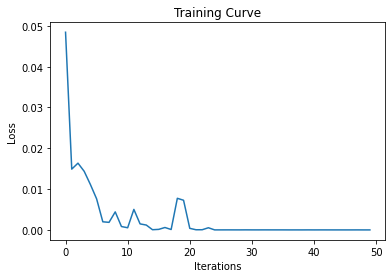

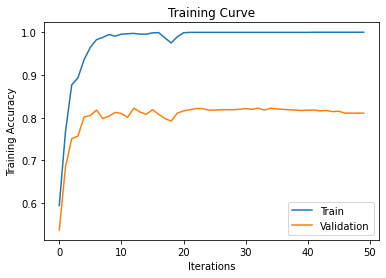

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8107142857142857


In [ ]:
baseModel2 = BaselineModel2()

use_cuda = True

if use_cuda and torch.cuda.is_available(): 
    baseModel2.cuda()
    print("CUDA is available! Training on GPU ...")
else:
    print("CUDA is not available. Training on CPU ...")

#train on small dataset
train(baseModel2, train_set, val_set, batch_size=32, lr=0.001, num_epochs=50)

##Test results
- batch_size=64, lr=0.001, num_epochs=10 || Training: 0.1366 Validation: 0.1410
- batch_size=64, lr=0.0001, num_epochs=5 || Training: 0.0714 Validation: 0.0714
- batch_size=64, lr=0.0001, num_epochs=10 || Training: 0.1214 Validation: 0.1142
- batch_size=64, lr=0.0001, num_epochs=20 || Training: 0.1818 Validation: 0.1919
- batch_size=64, lr=0.0001, num_epochs=30 || Training: 0.2467 Validation: 0.2482
- batch_size=64, lr=0.0001, num_epochs=40 || Training: 0.2360 Validation: 0.1973
- batch_size=64, lr=0.0005, num_epochs=40 || Training: 0.2864 Validation: 0.27857
- batch_size=64, lr=0.0005, num_epochs=50 || Training: 0.2824 Validation: 0.2392
- batch_size=32, lr=0.0001, num_epochs=50 || Training: 0.2020 Validation: 0.2107
- batch_size=64, lr=0.0005, num_epochs=30 || Training: 0.2613 Validation: 0.2464
- batch_size=64, lr=0.0005, num_epochs=60 || Training: 0.2961 Validation: 0.2571
- batch_size=64, lr=0.0005, num_epochs=70 || Training: 0.3509 Validation: 0.3366
- batch_size=64, lr=0.0005, num_epochs=90 || Training: 0.3431 Validation: 0.2821
- batch_size=64, lr=0.0005, num_epochs=100 || Training: 0.430 Validation: 0.3446
**- batch_size=64, lr=0.0005, num_epochs=110 || Training: 0.4366 Validation: 0.3321**
- batch_size=64, lr=0.00001, num_epochs=100 || Training: 0.1408 Validation: 0.1402
- batch_size=32, lr=0.0003, num_epochs=100 || Training: 0.3667 Validation: 0.3053
- batch_size=32, lr=0.0005, num_epochs=100 || Training: 0.20 Validation: 0.20
- batch_size=32, lr=0.0001, num_epochs=100 || Training: 0.2086 Validation: 0.2035
- batch_size=32, lr=0.0005, num_epochs=120 || Training: 0.526 Validation: 0.388
- batch_size=32, lr=0.0003, num_epochs=120 || Training: 0.2658 Validation: 0.2071
- batch_size=32, lr=0.0005, num_epochs=200 || Training: 0.3238 Validation: 0.2268

Using ReLu:
- batch_size=32, lr=0.0001, num_epochs=100 || Training: 0.993 Validation: 0.773
- batch_size=32, lr=0.0005, num_epochs=100 || Training: 1.0 Validation: 0.786
- batch_size=32, lr=0.001, num_epochs=50 || Training: 1.0 Validation: 0.8107

# CNN Model

In [ ]:
#primary model (CNN)

# Convolutional Neural Network Architecture
class CNN_Model(nn.Module):
    def __init__(self, change_kernel_sizes = [5, 10], name = "CNN"):
        super(CNN_Model, self).__init__()
        self.name = name # Used for saving different Hyperparameter results

        self.conv1 = nn.Conv2d(3, 5, change_kernel_sizes[0]) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, change_kernel_sizes[1]) #in_channels, out_chanels, kernel_size
        
        # Calculations for input size of first fully connected layer
        self.x1 = floor((135-change_kernel_sizes[0]+1)/2) #divide by 2 for pooling
        self.x2 = floor((self.x1-change_kernel_sizes[1]+1)/2) #floor for .5 values
        
        self.fc1 = nn.Linear(10 * self.x2 * self.x2, 30) #See Calculations (if needed)
        self.fc2 = nn.Linear(30, 14) #Suzy: changed number of output layers

    def forward(self, x):
        z1 = self.pool(F.relu(self.conv1(x))) #layer1CNN
        z2 = self.pool(F.relu(self.conv2(z1))) #layer2CNN
        z2 = z2.view(-1, 10 * self.x2 * self.x2)
        z3 = F.relu(self.fc1(z2)) #layer3NN
        z4 = self.fc2(z3) #layer4NN
        return z4

# 2 Convolutional layers, 2 Pooling layers, 2 Fully connected layers.'
# Will use the softmax activation function on the final layer with nn.CrossEntropyLoss() for classifying mathematical images.

# Calculations:
# x: 3*135*135 --> conv1: 5*131*131 --> maxpool: 5*65*65 --> conv2: 10*61*61 --> maxpool: 10*30*30
# input to first Fully Connected layer = 10*30*30

In [ ]:
#training on our CNN model

mainCNNModel = CNN_Model()

batch_size = 20
lr = 0.001
num_epochs = 30

use_cuda = True

if use_cuda and torch.cuda.is_available():
    mainCNNModel.cuda()
    print("CUDA is available! Training on GPU ...")
else:
    print("CUDA is not available. Training on CPU ...")

#train on small dataset
train(mainCNNModel, train_set, val_set, batch_size, lr, num_epochs)

In [ ]:
# Compute the saved "best" model results (no Training needed)

Compute_Model = CNN_Model()

# These Hyperparamters are just for Reference (Pretrained)!
batch_size = 20
lr = 0.001
num_epochs = 30

use_cuda = True

if use_cuda and torch.cuda.is_available():
    Compute_Model.cuda()
    print("CUDA is available!\n")
else:
    print("CUDA is not available.\n")

compute_best_model(Compute_Model, batch_size, lr, num_epochs)

CUDA is available!

Training Accuracy:  0.999702380952381
Validation Accuracy:  0.8553571428571428
Test Accuracy: 0.8669642857142857


##Test results (CNN Model)
**With the Architecture:** 
*   2 Convolutional Layers:
 *   1st Layer: 5 Feature Maps (output channels), Kernel Size = 5
 *   2nd Layer: 10 Feature Maps (output channels), Kernel Size = 5
*   2 Pooling Layers:
 *   Kernel Size = 2
 *   Stride = 2
*   2 Fully Connected Layers
 *   1st Layer: 10 * 30 * 30 Hidden units
 *   2nd Layer: 30 Hidden units

**With the Hyperparameters:** 

- batch_size=64, lr=0.01, num_epochs=10 || Training: 0.9729 Validation: 0.6866
- batch_size=64, lr=0.001, num_epochs=10 || Training: 0.9845 Validation: 0.7607
- batch_size=64, lr=0.001, num_epochs=30 || Training: 0.9976 Validation: 0.7420
- batch_size=64, lr=0.0001, num_epochs=10 || Training: 0.6455 Validation: 0.5589
- **batch_size=64, lr=0.0001, num_epochs=20 || Training: 0.7780 Validation: 0.6705**
- batch_size=64, lr=0.0001, num_epochs=30 || Training: 0.7524 Validation: 0.6196
- batch_size=64, lr=0.0005, num_epochs=30 || Training: 0.9107 Validation: 0.7116
- batch_size=32, lr=0.0001, num_epochs=20 || Training: 0.7726 Validation: 0.6652
- batch_size=128, lr=0.0001, num_epochs=20 || Training: 0.5670 Validation: 0.5063
- batch_size=32, lr=0.0001, num_epochs=30 || Training: 0.8580 Validation: 0.7152
- batch_size=128, lr=0.0001, num_epochs=30 || Training: 0.6318 Validation: 0.5813
- batch_size=128, lr=0.0001, num_epochs=40 || Training: 0.6702 Validation: 0.5830
- **batch_size=128, lr=0.0005, num_epochs=30 || Training: 0.9795 Validation: 0.8080**
- batch_size=128, lr=0.001, num_epochs=30 || Training: 0.9857 Validation: 0.7429

**Best:**
- batch_size=20, lr=0.001, num_epochs=30  || Training: 0.9997 Validation: 0.8554 Testing: 0.8670



#Computation

In [ ]:
def load_best_model(model, batch_size, learning_rate, epoch):
### Loading the best_model ###
  # Upload the saved model file to Colab
  # Use the Main Model & the Hyperparameters corresponding to the Best Model
  # Then, use the best_model for Computation

  best_model = model
  best_model_path = get_model_name(best_model.name, batch_size, learning_rate, epoch)
  state = torch.load(best_model_path)
  best_model.load_state_dict(state)
  
  return best_model

In [ ]:
def get_prediction(model, input_loader):

  output_list = []

  for imgs, labels in iter(input_loader):
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
      #############################################
      output_list += model(imgs)
      print(model(imgs))
    
  return output_list


In [ ]:
def string2int(output_list):
  for i in range(len(output_list)):
    if(output_list[i] == 'zero'):
      output_list[i] = 0
    elif(output_list[i] == 'one'):
      output_list[i] = 1
    elif(output_list[i] == 'two'):
      output_list[i] = 2
    elif(output_list[i] == 'three'):
      output_list[i] = 3
    elif(output_list[i] == 'four'):
      output_list[i] = 4
    elif(output_list[i] == 'five'):
      output_list[i] = 5
    elif(output_list[i] == 'six'):
      output_list[i] = 6
    elif(output_list[i] == 'seven'):
      output_list[i] = 7
    elif(output_list[i] == 'eight'):
      output_list[i] = 8
    elif(output_list[i] == 'nine'):
      output_list[i] = 9
      
  return output_list


In [ ]:
def get_computation(output_list):
  result = 0

  if(output_list[1] == 'plus'):
    result = output_list[0] + output_list[2]
  elif(output_list[1] == 'minus'):
    result = output_list[0] - output_list[2]
  elif(output_list[1] == 'times'):
    result = output_list[0] * output_list[2]
  elif(output_list[1] == 'div'):
    result = output_list[0] / output_list[2]

  return result

Predicted labels are: 
four
minus
one


Converted to integer: 
4
minus
1


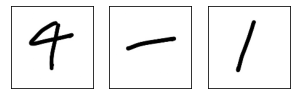

In [ ]:
import os
import torchvision.models

user_name = 'Suzy'

# Dataset folder location on Google Drive
if(user_name == 'HeeSeung'):
  input_img_folder = '/content/drive/My Drive/APS360 Colab Notebooks/Group 22/InputFolder'
elif(user_name == 'Suzy'):
  input_img_folder = '/content/drive/MyDrive/APS360_Group_22/InputFolder9'
elif (user_name == 'Grace'):
  input_img_folder = '/content/drive/MyDrive/Y3/APS360 Group 22/InputFolder'

# Transform Images to Tensors of pixel size 135 x 135
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((135, 135))])

input_set = torchvision.datasets.ImageFolder(input_img_folder, transform=transform)
input_loader = torch.utils.data.DataLoader(input_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

#plotting code starts here--------------------
dataiter = iter(input_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

## plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(5, 4))
for idx in np.arange(3):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#plotting code ends here------------------------

alexNet = torchvision.models.alexnet(pretrained=True)
batch_size_alex = 1
num_workers_alex = 1

input_loader_alex = torch.utils.data.DataLoader(input_set, batch_size=batch_size_alex, num_workers=num_workers_alex, shuffle=False)

c = 0
for img,lbl in input_loader_alex:
  features = alexNet.features(img)
  tensor_features = torch.from_numpy(features.detach().numpy())
  folder = '/content/drive/MyDrive/APS360_Group_22/InputFolder9/input'
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(tensor_features.squeeze(0), folder+'/'+str(c)+'.tensor')
  c+=1

input_features = torchvision.datasets.DatasetFolder('/content/drive/MyDrive/APS360_Group_22/InputFolder9', loader=torch.load, extensions=('.tensor'))

batch_size_features = 32
num_workers_features = 1

input_loader_feature = torch.utils.data.DataLoader(input_features, batch_size=batch_size_features, num_workers=num_workers_features, shuffle=False)

dataiter = iter(input_loader_feature)
features, labels = dataiter.next()

#input_loader holds three input images (ex. 5, +, 3)
#input_loader = torch.utils.data.DataLoader(input_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)

output_list = []
result = 0

best_model = AlexClassifier()
best_model.load_state_dict(torch.load('/content/drive/MyDrive/APS360_Group_22/best_model'))

use_cuda = True


    
### Loading the best_model ###
# Use the Main Model & the Hyperparameters corresponding to the Best Model
#best_model = load_best_model(mainCNNModel, batch_size=20, learning_rate=0.001, epoch=30)
## I put mainCNN and hyperparameters as default best ##


#getting output from model's prediction
#output_list = get_prediction(best_model, input_loader)
for entry, lbl in iter(input_loader_feature):
  out = best_model(entry)
  pred = out.max(1,keepdim=True)[1]
  for id in pred:
    output_list += [classes[id]]
  break;



#printing predicted labels
print('Predicted labels are: ')
for i in range(len(output_list)):
  print(output_list[i])
  
print('\n')
#convert string valued numbers to int
output_list = string2int(output_list)

print('Converted to integer: ')
for i in range(len(output_list)):
  print(output_list[i])

In [ ]:
#final computation result of our model
result = get_computation(output_list)

print('Computed result is:',result)

Computed result is: 3


# AlexNet Model 

In [ ]:
import os
import torchvision.models
alexNet = torchvision.models.alexnet(pretrained=True)

master = math_img_folder

batch_size_alex = 1
num_workers_alex = 1

training_loader_alex = torch.utils.data.DataLoader(train_set, batch_size=batch_size_alex, num_workers=num_workers_alex, shuffle=True)
validation_loader_alex = torch.utils.data.DataLoader(val_set, batch_size=batch_size_alex, num_workers=num_workers_alex, shuffle=True)
testing_loader_alex = torch.utils.data.DataLoader(test_set, batch_size=batch_size_alex, num_workers=num_workers_alex, shuffle=True)

In [ ]:
c = 0
for img,lbl in training_loader_alex:
  features = alexNet.features(img)
  tensor_features = torch.from_numpy(features.detach().numpy())
  folder = master + '/Training/' + str(classes[lbl])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(tensor_features.squeeze(0), folder+'/'+str(c)+'.tensor')
  c+=1

In [ ]:
c = 0
for img,lbl in validation_loader_alex:
  features = alexNet.features(img)
  tensor_features = torch.from_numpy(features.detach().numpy())
  folder = master + '/Validation/' + str(classes[lbl])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(tensor_features.squeeze(0), folder+'/'+str(c)+'.tensor')
  c+=1

In [ ]:
c = 0
for img,lbl in testing_loader_alex:
  features = alexNet.features(img)
  tensor_features = torch.from_numpy(features.detach().numpy())
  folder = master + '/Testing/' + str(classes[lbl])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(tensor_features.squeeze(0), folder+'/'+str(c)+'.tensor')
  c+=1

In [ ]:
master = math_img_folder

train_features = torchvision.datasets.DatasetFolder(master + '/Training', loader=torch.load, extensions=('.tensor'))
val_features = torchvision.datasets.DatasetFolder(master + '/Validation', loader=torch.load, extensions=('.tensor'))
test_features = torchvision.datasets.DatasetFolder(master + '/Testing', loader=torch.load, extensions=('.tensor'))

batch_size_features = 32
num_workers_features = 1

train_loader_feature = torch.utils.data.DataLoader(train_features, batch_size=batch_size_features, num_workers=num_workers_features, shuffle=True)
val_loader_feature = torch.utils.data.DataLoader(val_features, batch_size=batch_size_features, num_workers=num_workers_features, shuffle=True)
test_loader_feature = torch.utils.data.DataLoader(test_features, batch_size=batch_size_features, num_workers=num_workers_features, shuffle=True)

dataiter = iter(train_loader_feature)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

In [ ]:
torch.manual_seed(10)

class AlexClassifier(nn.Module):
  def __init__(self, name="AlexNet_Classifier"):
    super(AlexClassifier, self).__init__()
    self.name = name # Used for saving different Hyperparameter results

    self.conv1 = nn.Conv2d(256, 512, 2)
    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(512*1*1, 32)
    self.fc2 = nn.Linear(32, 14)

  def forward(self, features):
    x = self.pool(F.relu(self.conv1(features)))
    x = x.view(-1, 512*1*1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x, dim=1)

In [ ]:
def train_AlexNet(model, train_dataset, val_dataset, batch_size=128, num_epochs=5, learn_rate=0.001):
    torch.manual_seed(10)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # training
    print ("Begin Training...")
    n = 0
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_images = 0
        for imgs, labels in iter(train_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1          
        
        # track accuracy
        train_acc[epoch] = get_accuracy(model, train_loader, val_loader, train=True)
        val_acc[epoch] = get_accuracy(model, train_loader, val_loader, train=True)

        print(("Epoch {}: Train acc: {} ||" + "Validation acc: {}").format(epoch, train_acc[epoch], val_acc[epoch]))
            
    epochs = np.arange(1, num_epochs + 1)
    
    return train_acc, val_acc, epochs

In [ ]:
AlexNet_Model = AlexClassifier()

use_cuda = True

if use_cuda and torch.cuda.is_available():
    AlexNet_Model.cuda()
    print("CUDA is available! Training on GPU ...")
else:
    print("CUDA is not available. Training on CPU ...")

#train on small dataset
train(AlexNet_Model, train_features, val_features,batch_size=128, lr=0.001, num_epochs=20)



---



*   batch_size=128, lr=0.001, num_epochs=20 || Training: 0.9268 Validation: 0.9098



# Autoencoder

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.enc1 = nn.Linear(784,256)
    self.enc2 = nn.Linear(256, 128)
    self.enc3 = nn.Linear(128,64)
    self.enc4 = nn.Linear(64,32)
    self.enc5 = nn.Linear(32,16)

    # decoder
    self.dec1 = nn.Linear(16,32)
    self.dec2 = nn.Linear(32,64)
    self.dec3 = nn.Linear(64,128)
    self.dec4 = nn.Linear(128,256)
    self.dec5 = nn.Linear(256, 784)
  
  def forward(self,x):
    x = F.relu(self.enc1(x))
    x = F.relu(self.enc2(x))
    x = F.relu(self.enc3(x))
    x = F.relu(self.enc4(x))
    x = F.relu(self.enc5(x))

    x = F.relu(self.dec1(x))
    x = F.relu(self.dec2(x))
    x = F.relu(self.dec3(x))
    x = F.relu(self.dec4(x))
    x = F.relu(self.dec5(x))
    return x


In [ ]:
#training code

def train(model, train_dataset, val_dataset, batch_size=64, lr=0.001, num_epochs=1):

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)

    iters, losses, train_acc, val_acc = [], [], [], []
    
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
                 
            out = model(imgs)             # forward pass
            loss = criterion(out, imgs)   # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
        n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
auto = Autoencoder()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    auto.cuda()
    print("CUDA is available! Training on GPU ...")
else:
    print("CUDA is not available. Training on CPU ...")
train(auto, train_set, val_set, batch_size=64, lr=0.001, num_epochs=100)

###-------------------------- MODIFICATION LOG ----------------------------


- Suzy: I just copy pasted the code to get the datasets from kaggle (needs modification)
- Suzy: Added baseline model(needs modification)
---
- Hee: I added the rough CNN model (main model) with arbitrary parameters
- Hee: Need to change Kernel Sizes, # of Conv layers, # of Fully connected layers, etc.
- Hee: Created a different method for loading kaggle data
- Hee: I manually divided 240/80/80 (Train/Val/Test) images per class and uploaded to Google Doc
- Hee: Created new data cleaning method (different from Suzy, using Kaggle) by using images from Google Drive.
- Hee: I created "user_name" because the path to the dataset is different individually
---
- Suzy: Modified parameters for the baseline model
- Suzy: Added training function (needs modification: maybe change the loss function?)
- Suzy: Added baseline model training code
- Suzy: Added our main model training code(MathSymbolClassifier)
---
- Suzy, Grace: Fixed errors in data cleaning (changed order of classes and renamed images)
- Suzy, Grace: Completed data cleaning.
---
- Grace: commented out plotting in data cleaning section (for simplicity when running the codes)
- Grace: training baseline model (test results documented below the function)
---
- Grace, Suzy: training baseline model (test results documented below the function)
- Suzy: added code for computing final result (with helper functions: get_computation, get_prediction, string2int)
---
- Hee: # Fixed the number of inputs to 135 from 224 (which was causing the error) in Main Model
- Hee: Added Calculations as a comment so next time it is easily changeable 
- Hee: Trained the Main CNN Model to a certain level (can be better)
- Hee: Best was Training: 0.9795 & Validation: 0.8080
---
- Richard: Added Pretrained AlexNet
- Richard: Added code to compute AlexNet features
- Richard: Added preliminary model to train AlexNet features
- Richard: Added Alternative training function
- Richard: Added preliminary testing results
---
- Grace: Added autoencoder model
---
- Hee: Added model_path & torch.save in Training code
- Hee: Made get_model_name under Training code (used for saving the current model to a file)
- Hee: Added model.eval() & model.train() in get_accuracy & training code (to   explicityly show and guarantee that mode has changed)
- Hee: Made compute_best_model to use the saved files to compute results, and not retrain with the same hyperparameters (for any Net).
- Hee: Made load_best_model to load the best trained model and use the best_model for computation.
---
- Suzy: Finished debugging the computation code (computes correct result)
- Suzy&Grace: Created new handwritten images
- Suzy: Cleaned new data to be used in computation test